In [ ]:
#Step 3: Establish CNN-LSTM Model

In [35]:
!pip install pandas numpy scikit-learn torch matplotlib
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=a3bbc994da9049043f1d853a9510a39aee9c7baf2c46df5449cf8fc0f2ed7784
  Stored in directory: c:\users\24716\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [24]:
# Load Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator  
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands
df = pd.read_csv(r"xxxxxxxxxx") #read the price data
features_cols = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT', 'price_change', 'price_range', 'vwap']


In [26]:
# Create tech indicator
df["rsi_14"] = RSIIndicator(close=df["close"], window=14).rsi()
macd = MACD(close=df["close"])
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()
df["ema_5"] = EMAIndicator(close=df["close"], window=5).ema_indicator()
df["ema_20"] = EMAIndicator(close=df["close"], window=20).ema_indicator()
bb = BollingerBands(close=df["close"], window=20)
df["bb_upper"] = bb.bollinger_hband()
df["bb_middle"] = bb.bollinger_mavg()
df["bb_lower"] = bb.bollinger_lband()
df["momentum_10"] = df["close"] - df["close"].shift(10)

In [28]:
# Preprocess
future_close = df['close'].shift(-1)
df['label'] = (future_close > df['close']).astype(int)
df.dropna(inplace=True)

features_cols = [
    'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT',
    'price_change', 'price_range', 'vwap',
    'rsi_14', 'macd', 'macd_signal',
    'ema_5', 'ema_20',
    'bb_upper', 'bb_middle', 'bb_lower',
    'momentum_10'
]

features = df[features_cols].values
labels = df['label'].values

scaler = StandardScaler()                       #standardize the scaler
features_scaled = scaler.fit_transform(features)  


In [30]:
# Create Sequences
def create_sequences(features, labels, window=24):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window].astype(np.float32))
        y.append(labels[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(features_scaled[-100000:], labels[-100000:], window=24)

In [32]:
# Dataset Split 
split = int(0.8 * len(X))                        #split data into train list and text list
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


In [34]:
# Define Model 
class LSTMTrader(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMTrader(input_size=X.shape[2])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [36]:
# Train Model
train_losses = []

for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # record avg_loss
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

Epoch 1: Loss = 0.4608
Epoch 2: Loss = 0.4542
Epoch 3: Loss = 0.4530
Epoch 4: Loss = 0.4519
Epoch 5: Loss = 0.4513
Epoch 6: Loss = 0.4503
Epoch 7: Loss = 0.4495
Epoch 8: Loss = 0.4488
Epoch 9: Loss = 0.4481
Epoch 10: Loss = 0.4472


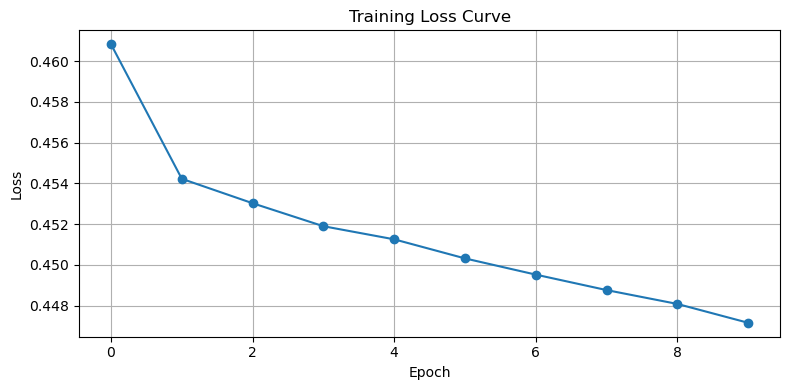

In [38]:
# Loss Curve Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Test Accuracy Evaluate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {correct / total:.2%}")

Test Accuracy: 81.89%
